In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pickle import dump

from sklearn.metrics import accuracy_score

#4pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

#4pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
#Load dataset
ds = pd.read_csv('STMECH_AUS_SS_V1.txt', delimiter='\t')


In [15]:
#Remove the columns (Zr, Ta, V, W ...) with 0 values
ds_chem_1 = ds.iloc[:, 0:7]
ds_chem_2 = ds.iloc[:, 9]
ds_chem_3 = ds.iloc[:, 11:19]
mech_prop = ds.iloc[:,30:33]
mech_prop_temp = ds.iloc[:,29]

#Create the dataset X and Y
ds_chem_raw = pd.concat([ds_chem_1, ds_chem_2, ds_chem_3, mech_prop, mech_prop_temp], axis=1)


# #Elonagation has 'Na' values, select the raws and remove from dataset
ds_chem = ds_chem_raw[ds_chem_raw['El(%)'].str.contains('Na') == False]

#Remove 473K, 573K, 673K,873K,1073K, 1023K
data_298 = ds_chem[ ds_chem['Temperature (K)'] == 298 ]
data_373 = ds_chem[ ds_chem['Temperature (K)'] == 373 ]
data_773 = ds_chem[ ds_chem['Temperature (K)'] == 773 ]
data_973 = ds_chem[ ds_chem['Temperature (K)'] == 973 ]

data_raw = pd.concat([data_298.iloc[:, 16:19], data_373.iloc[:, 16:19], data_773.iloc[:, 16:19], data_973.iloc[:, 16:19]])
labels_raw = pd.concat([data_298.iloc[:, 19], data_373.iloc[:, 19], data_773.iloc[:, 19], data_973.iloc[:, 19]])

data_raw = data_raw.astype(float)
labels_raw.replace([298, 373, 773, 973], [0,1,2,3], inplace = True)

#train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data_raw, labels_raw, test_size=0.25, random_state=0, shuffle=True)

#Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.fit_transform(X_test_raw)

#Save scaler
dump(scaler, open('scaler.pkl', 'wb'))


#Convert to 2D PyTorch tesnor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)#.reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)#.reshape(-1, 1)




In [16]:
#Create model

class class_model(nn.Module):
    def __init__(self):
        super().__init__()

        #input layer
        self.input = nn.Linear(3,32)


        # hidden layer
        self.hidden1 = nn.Linear(32,32)

        # hidden layer
        # self.hidden2 = nn.Linear(64,64)

        #output layer
        self.output = nn.Linear(32,4)

        #Softmax
        self.act_output = nn.Softmax(dim=1)

    #forwards
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        # x = F.relu(self.hidden2(x))
        x = self.output(x)
        x = self.act_output(x)
        return x

model = class_model()

lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
      

In [17]:
#Train the model
epoch = 300

losses_train = torch.zeros(epoch)
accuracy_train = torch.zeros(epoch)
losses_test = torch.zeros(epoch)
accuracy_test = torch.zeros(epoch)

for epochi in range(epoch):
    model.train()
    y_pred_train = model(X_train)
    loss_train   = lossfunc(y_pred_train, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    #Calculate losses
    losses_train[epochi] = loss_train
    y_predicted_train = torch.argmax(y_pred_train, dim=1)
    accuracy_train[epochi] = accuracy_score(y_train, y_predicted_train)

    #test the model
    model.eval()
    with torch.inference_mode():
        y_pred_test = model(X_test)
        loss_test = lossfunc(y_pred_test, y_test)
        losses_test[epochi] = loss_test
        y_predicted_test = torch.argmax(y_pred_test, dim=1)
        accuracy_test[epochi] = accuracy_score(y_test, y_predicted_test)

acc_train = 100 * accuracy_train[epoch - 1]
acc_test = 100 * accuracy_test[epoch - 1]

#Save teh weights
torch.save(model.state_dict(),'aus_ss.pt')

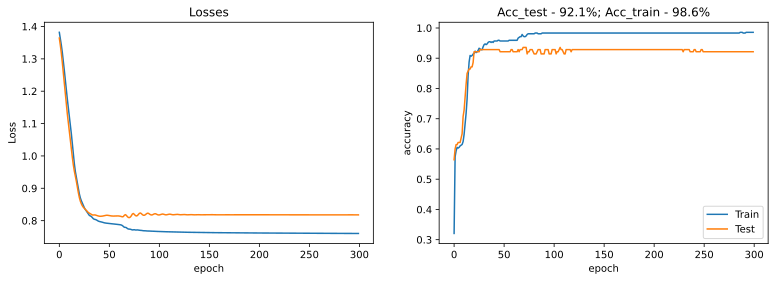

In [18]:
#Plot losses and accuracy

fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses_train.detach(), label='Train')
ax[0].plot(losses_test.detach(), label='Test')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(accuracy_train.detach(), label='Train')
ax[1].plot(accuracy_test.detach(), label='Test')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title(f'Acc_test - {acc_test:.1f}%; Acc_train - {acc_train:.1f}%')
ax[1].legend()
plt.show()

In [19]:
# compute the predictions

model.eval()
predictions = model(X_test)
pred = torch.argmax(predictions, dim=1)
#pred, y_test

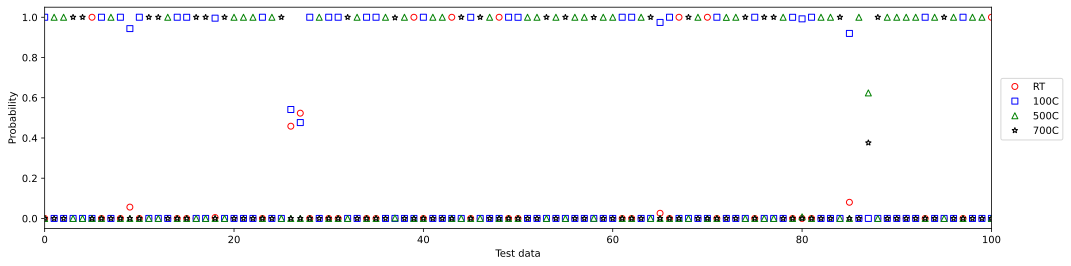

In [24]:
#Plot probabilities in the range from 0 to 100

fig = plt.figure(figsize=(17,4))

colorshape = [  'ro','bs','g^','k*' ]
for i in range(4):
  plt.plot(predictions[:,i].detach(),colorshape[i],markerfacecolor='w')

plt.xlabel('Test data')
plt.ylabel('Probability')
plt.legend(['RT','100C','500C', '700C'],loc=(1.01,.4))
plt.xlim(0,100)
plt.show()

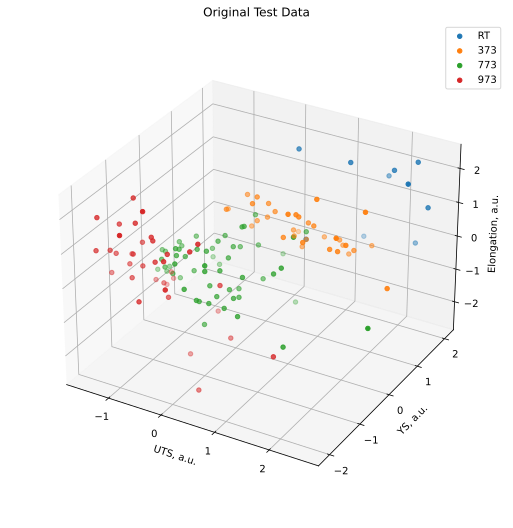

In [26]:
#Plot of scaled test data

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.scatter(X_test[np.where(y_test==0)[0],0].detach(),X_test[np.where(y_test==0)[0],1].detach(),X_test[np.where(y_test==0)[0],2], label='RT')
ax.scatter(X_test[np.where(y_test==1)[0],0].detach(),X_test[np.where(y_test==1)[0],1].detach(),X_test[np.where(y_test==1)[0],2], label='373')
ax.scatter(X_test[np.where(y_test==2)[0],0].detach(),X_test[np.where(y_test==2)[0],1].detach(),X_test[np.where(y_test==2)[0],2], label='773')
ax.scatter(X_test[np.where(y_test==3)[0],0].detach(),X_test[np.where(y_test==3)[0],1].detach(),X_test[np.where(y_test==3)[0],2], label='973')


ax.set_xlabel('UTS, a.u.')
ax.set_ylabel('YS, a.u.')
ax.set_zlabel('Elongation, a.u.')
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_title('Original Test Data')
#ax.view_init(55,10)
ax.legend()
plt.show()


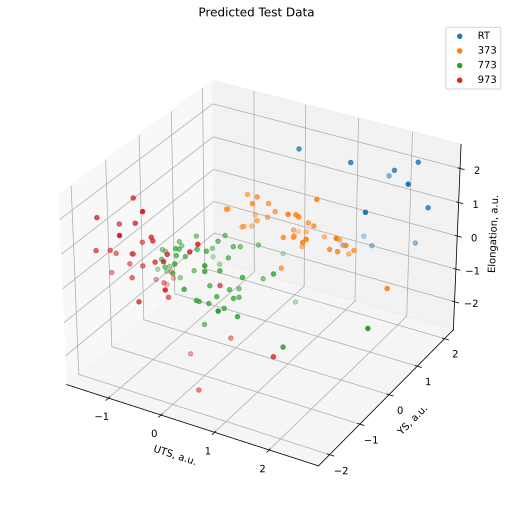

In [28]:
#Plot of scaled predicted test data

y_pred_final = torch.argmax(predictions, dim=1)

fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.scatter(X_test[np.where(y_pred_final==0)[0],0],X_test[np.where(y_pred_final==0)[0],1],X_test[np.where(y_pred_final==0)[0],2], label='RT')
ax.scatter(X_test[np.where(y_pred_final==1)[0],0],X_test[np.where(y_pred_final==1)[0],1],X_test[np.where(y_pred_final==1)[0],2], label='373')
ax.scatter(X_test[np.where(y_pred_final==2)[0],0],X_test[np.where(y_pred_final==2)[0],1],X_test[np.where(y_pred_final==2)[0],2], label='773')
ax.scatter(X_test[np.where(y_pred_final==3)[0],0],X_test[np.where(y_pred_final==3)[0],1],X_test[np.where(y_pred_final==3)[0],2], label='973')
ax.set_xlabel('UTS, a.u.')
ax.set_ylabel('YS, a.u.')
ax.set_zlabel('Elongation, a.u.')
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_title('Predicted Test Data')
#ax.view_init(55,10)
ax.legend()


plt.show()

